# Bradan Fleming

In Frustrated Flyers, we analyze COVID-19's impact on commercial airlines and their passengers by relating flight data to data from the early COVID-19 timeline.

In my exploratory data analysis (EDA), I look at flight disruptions and pandemic information during February 2020. This is similar to what Aakash does for January 2020.

After my EDA, I relate flight disruptions to pandemic events. This leads me to conclude that there is a tangible relationship between flight disruptions and COVID-19 cases.

In [ ]:
# Run this before continuing.
# We need these packages for the analysis!
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
sns.set_theme(style='white', font_scale=1.2, palette='bright')

---

## Research question

**How has the early response to COVID-19 affected decisions made by commercial airlines? How have those decisions disrupted consumer flight as a whole?**

I will analyse the cause of spikes in cancellations and delays of consumer flights by relating them to origin and destination countries and determining which regions were most strongly affected by flight disruptions. This data was collected by the US government, so I'm unsure how complete their logs of international flights are, and it only covers consumer flights. However, I think that should still provide enough information to identify a relationship between flight disruptions and events in the early COVID-19 timeline. This should help us better understand the relationship between COVID-19 and commerical airlines, and how that relationship evolved over time.

### Interests
* Which countries were affected the most by COVID-19.
    * By using the OpenFlights [airport database](https://github.com/jpatokal/openflights/blob/e3bc6dedbcceb8b7b74248a00dcd6207254da6bd/data/airports-extended.dat), we can find the locations of both the origin and destination of every flight.
* How do flight cancellations in countries relate to case counts and death counts both domestically and abroad.
    * It would be wise to restrict the scope of this to a specific health district or country that was most affected by cancellations.
* How do incoming flights affect the case counts of COVID-19 in different countries?
    * Once again, it would be wise to restrict the scope of this to a few notable areas.
* How can we minimize the effects of flight disruptions?
    * I do not expect to accomplish this, but I hope that better understanding this data leads to some actionable or interesting insight.

---

## Exploratory data analysis

I'm analysing this month separately because COVID-19 developed quite quickly, so it goes from 0 cases to hundreds of deaths quite quickly. Because of this, I think this month warrants its own analysis because each case is less significant at this point, and the pandemic is finally picking up speed.

### Datasets

The project as a whole involves four different datasets. I am interested in two of them: February 2020 flights, and total COVID-19 cases during February 2020.

In [ ]:
# Flight data
df1 = pd.read_csv('../data/raw/Feb_2020_ontime.csv').drop(columns=['DAY_OF_WEEK', 'Unnamed: 21']) # The unnamed column is NaN
# Calculate planned departure time
df1['Time'] = pd.to_datetime('2020-2-'+df1['DAY_OF_MONTH'].astype(str)+' '+df1['DEP_TIME_BLK'].str[:4], utc=True, errors='coerce')
# Roughly calculate departure delay
df1['Departure delay'] = df1['DEP_TIME']%100+df1['DEP_TIME']//100*60 - df1['DEP_TIME_BLK'].str[-4:-2].astype(int)*60 - df1['DEP_TIME_BLK'].str[-2:].astype(int) # Minutes since end of time block
df1['Departure delay'] = np.where(df1['Departure delay'] < 0, 0, df1['Departure delay']) # Discard negative delays
df1['Departure delay'] = np.where(df1['Departure delay'] > 1060, 0, df1['Departure delay']) # Discard flights mismarked due to time wraparound
# Show head
df1.head()

,DAY_OF_MONTH,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN,DEST_AIRPORT_ID,...,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,CANCELLED,DIVERTED,DISTANCE,Time,Departure delay
0,1,MQ,20398,MQ,N269NN,3825,13930,1393007,ORD,15370,...,1646.0,0.0,1600-1659,1820.0,0.0,0.0,0.0,585.0,2020-02-01 16:00:00+00:00,0.0
1,1,MQ,20398,MQ,N908AE,3829,12478,1247805,JFK,10693,...,1336.0,0.0,1300-1359,1458.0,0.0,0.0,0.0,765.0,2020-02-01 13:00:00+00:00,0.0
2,1,MQ,20398,MQ,N663AR,3831,11953,1195302,GNV,13303,...,844.0,0.0,0800-0859,1020.0,1.0,0.0,0.0,294.0,2020-02-01 08:00:00+00:00,0.0
3,1,MQ,20398,MQ,N618AE,3833,11298,1129806,DFW,14842,...,852.0,0.0,0800-0859,955.0,0.0,0.0,0.0,229.0,2020-02-01 08:00:00+00:00,0.0
4,1,MQ,20398,MQ,N618AE,3833,14842,1484202,SJT,11298,...,1024.0,0.0,1000-1059,1132.0,0.0,0.0,0.0,229.0,2020-02-01 10:00:00+00:00,0.0


This is just a list of flights, so it's not too interesting out of the gate (heh).

In [ ]:
# COVID-19 data
df2 = (pd.read_csv('../data/raw/WHO-COVID-19-global-data.csv')
       .query('Date_reported >= "2020-02-01" & Date_reported < "2020-03-01"')
       .assign(Country = lambda x: np.where(x.Country_code == 'US', 'United States', x.Country))
       .drop(columns=['WHO_region']))
df2 = df2.groupby('Date_reported').sum(numeric_only=True) # Sum the data across all countries and regions!
df2 = df2.reset_index() # Flatten the index
df2['Date_reported'] = pd.to_datetime(df2['Date_reported']) # Format as datetime
df2.head()

,Date_reported,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,2020-02-01,2112,11970,46,259
1,2020-02-02,2605,14575,103,362
2,2020-02-03,2836,17411,64,426
3,2020-02-04,3255,20666,66,492
4,2020-02-05,3948,24614,72,564


Wow, that's a lot of COVID-19 cases and deaths! I guess it was still called "the coronavirus" back then, wasn't it.

### Pandemic events

First, I'll get the new cases and deaths per day across all countries to see the spikes.  
I'd wager that half of the students in this class have _also_ made this exact plot, but this one is mine.

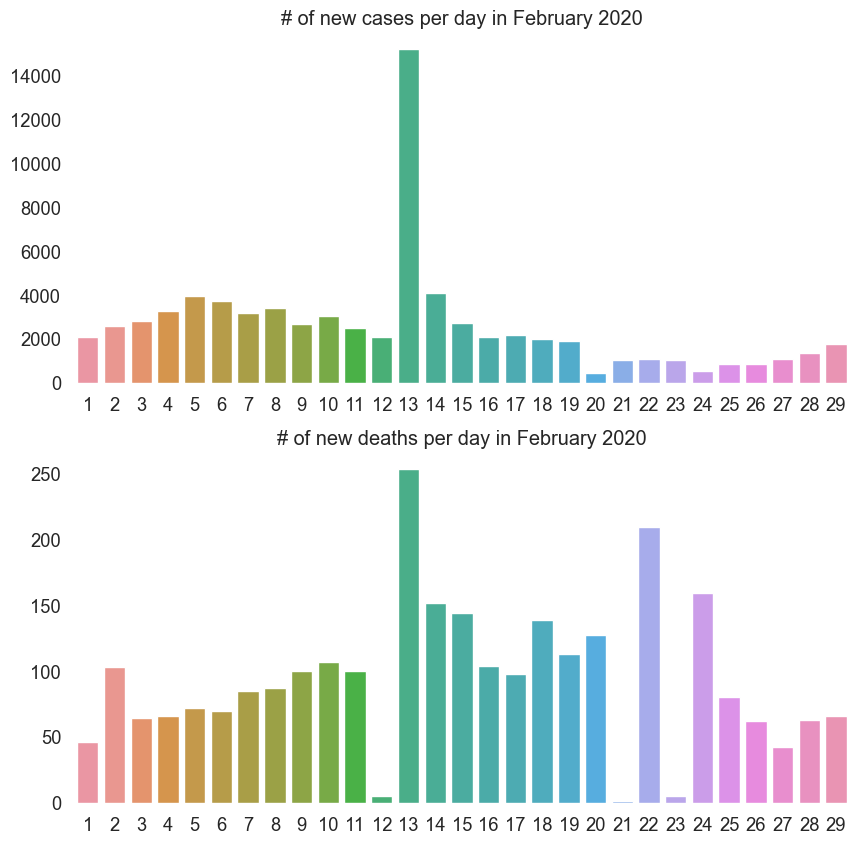

In [ ]:
# Date — # of cases, Date — # of deaths
fig, ax = plt.subplots(2,1, figsize=(10,10))
sns.barplot(df2, x=df2['Date_reported'].dt.day, y='New_cases', ax=ax[0])
ax[0].set(title='# of new cases per day in February 2020', xlabel='', ylabel='')
sns.barplot(df2, x=df2['Date_reported'].dt.day, y='New_deaths', ax=ax[1])
ax[1].set(title='# of new deaths per day in February 2020', xlabel='', ylabel='')
sns.despine(left=True, bottom=True)
plt.show()

These are pretty similar. There seem to be spikes on the 5th, 10th, 13th, and 22nd.  
**I am not sure what caused the dip and spike on the 12th and 13th**, but considering that deaths were very low on the 12th, I suspect that it might be an error in the data or reporting, so I'll take note of that.

### Flight disruptions

This is the part where I look for flight disruptions. I will begin by looking at delays.

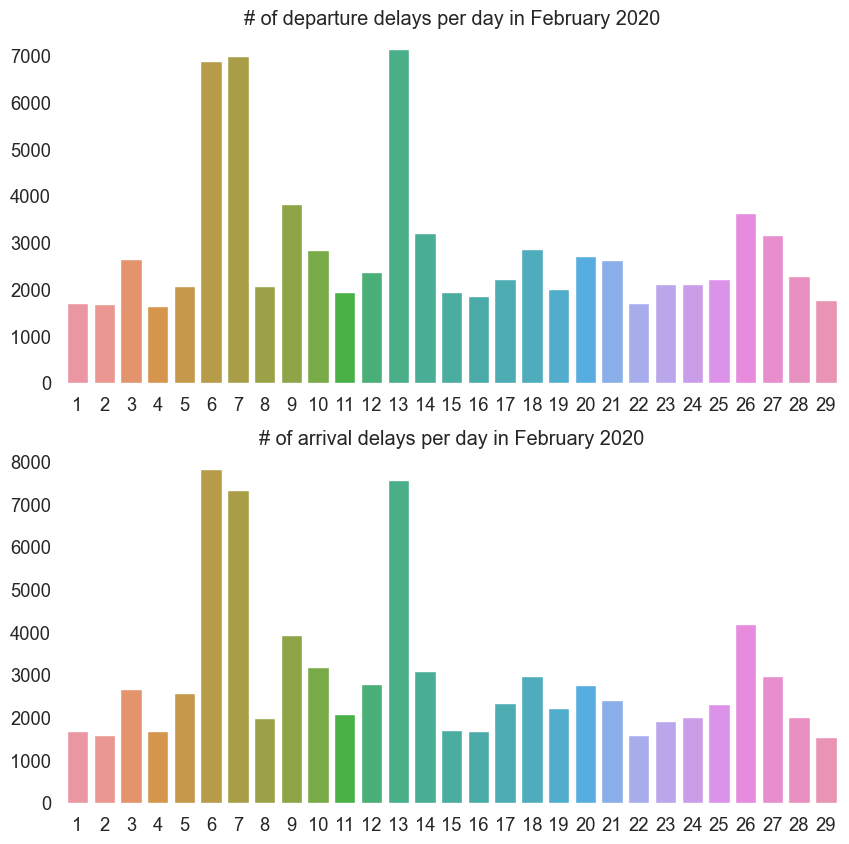

In [ ]:
# Date — # of delays (based on DEP_DEL15 and ARR_DEL15 indicators)
fig, ax = plt.subplots(2,1, figsize=(10,10))
sns.countplot(df1, x=df1.query('DEP_DEL15 == 1')['Time'].dt.day, ax=ax[0])
ax[0].set(title='# of departure delays per day in February 2020', xlabel='', ylabel='')
sns.countplot(df1, x=df1.query('ARR_DEL15 == 1')['Time'].dt.day, ax=ax[1])
ax[1].set(title='# of arrival delays per day in February 2020', xlabel='', ylabel='')
sns.despine(left=True, bottom=True)
plt.show()

Unsurprisingly, the departure and arrival delay distributions are very similar.  
The delays seem to fluctuate up and down, so I'm not seeing any big interesting disturbances here.  
Aakash's analysis finds a similar close relationship for flights in January 2020, so **it is safe to exclusively focus on departure delays**.

What if I calculate the total minutes of delay?

When importing the data, I added a "Departure delay" column that finds the difference between the actual departure time and the end of the departure time block, and discarded the value if it was negative (i.e., not delayed). This gives the number of minutes that each flight was delayed.

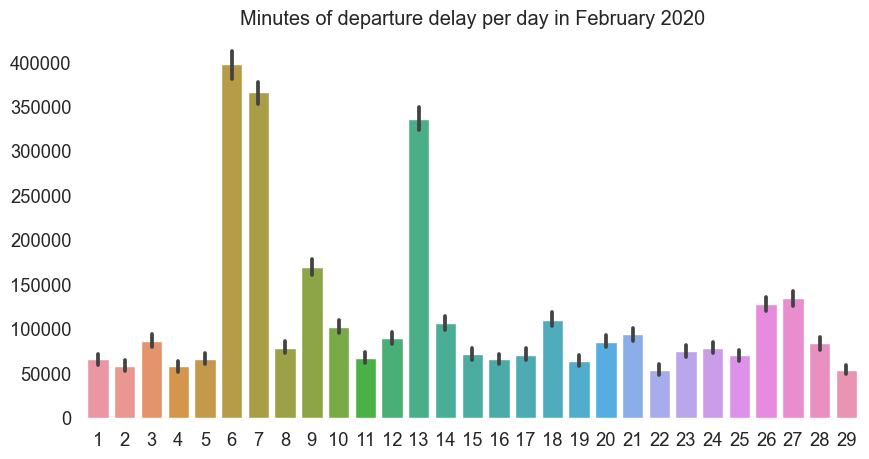

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.barplot(df1, x=df1['Time'].dt.day, y='Departure delay', ax=ax, estimator='sum')
ax.set(title='Minutes of departure delay per day in February 2020', xlabel='', ylabel='')
sns.despine(left=True, bottom=True)

The distribution of this graph is very similar to those of the departure delays, so I don't think I need to particularly focus on this one either.

What about cancellations?

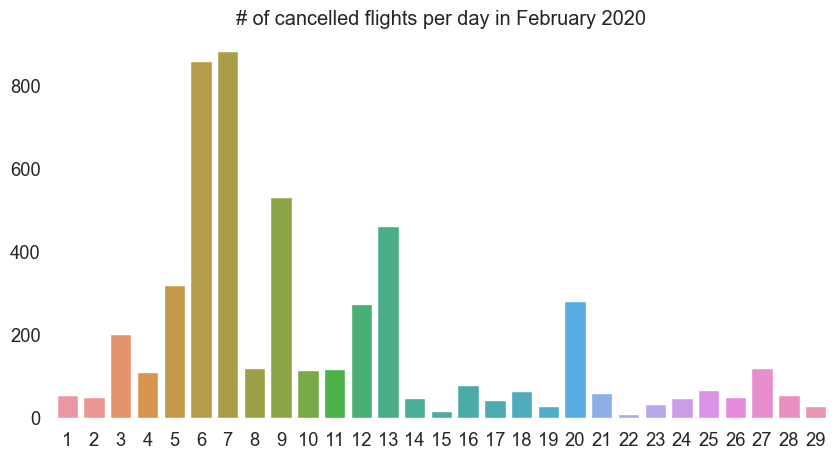

In [ ]:
# Date — # of cancellations
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(df1, x=df1.query('CANCELLED == 1')['Time'].dt.day, ax=ax)
ax.set(title='# of cancelled flights per day in February 2020', xlabel='', ylabel='')
sns.despine(left=True, bottom=True)
plt.show()

Yikes, these spikes are more noticeable! They are in similar positions to the delays, but they are in greater magnitude _relative to the rest of the data_.  
This might correspond to a pandemic-related event, so **I should pay attention to spikes near the 6th, 9th, 13th, 20th, and 27th**.  
After all, there were also spikes in COVID near the 5th, 10th, 13th, and 22nd.

See also: [Timeline of the COVID-19 pandemic in January 2020](https://en.wikipedia.org/w/index.php?title=Timeline_of_the_COVID-19_pandemic_in_February_2020&oldid=1145353712)

It seems that the pattern of flight disruptions is general, and **I can understand the general pattern of flight disruptions by analysing cancellations**.

---

## Data analysis

In this analysis, I will find a relationship between the spikes found in my exploratory data analysis.

Previously, my EDA looked at spikes, but I'm a different Bradan now: I'm more sophisticated.

### Data pipeline

First, I need to import the datasets. I will include the airports so I can identify the countries I need. The version in this notebook may not be the final version.

In [ ]:
# Import airports
airports = pd.read_csv('../data/raw/airports-extended.dat', header=None)

# Clean columns
airports = airports.rename(columns={1: 'Name',
                                    2: 'City',
                                    3: 'Country',
                                    4: 'IATA',
                                    5: 'ICAO'})
airports = airports.drop(columns=[0, 6, 7, 8, 9, 10, 11, 12, 13])

# Fix NaN
airports.loc[airports['IATA'] == "\\N", 'IATA'] = np.nan
airports.loc[airports['ICAO'] == "\\N", 'ICAO'] = np.nan

# Drop airports without IATA codes
airports = airports.dropna(subset='IATA')

airports.head()

,Name,City,Country,IATA,ICAO
0,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA
1,Madang Airport,Madang,Papua New Guinea,MAG,AYMD
2,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH
3,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ
4,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY


Next, I will import the flights for February 2020. This involves more wrangling. This has been converted to a method chain in `project_functions_bradan.py`.

In [ ]:
def process_time(df: pd.DataFrame, time_prefix: str):
    ''' Jankily convert times to datetimes '''
    # Estimated departure times
    df['Departure time (min)'] = pd.to_datetime(time_prefix+df['DAY_OF_MONTH'].astype(str)+' '+df['DEP_TIME_BLK'].str[:4], utc=True)
    df['Departure time (max)'] = pd.to_datetime(time_prefix+df['DAY_OF_MONTH'].astype(str)+' '+df['DEP_TIME_BLK'].str[-4:], utc=True)
    df.loc[df['Departure time (max)'] < df['Departure time (min)'], 'Departure time (max)'] += pd.DateOffset(days=1)

    # Actual departure time
    dt = df['DEP_TIME'].fillna(0).astype(int).astype(str).str.pad(4,'left','0')
    dt.loc[dt == '2400'] = '0000'
    df['Departure time'] = pd.to_datetime(time_prefix+df['DAY_OF_MONTH'].astype(str)+' '+dt, utc=True)

    # Actual arrival time
    at = df['ARR_TIME'].fillna(0).astype(int).astype(str).str.pad(4,'left','0')
    at.loc[at == '2400'] = '0000'
    df['Arrival time'] = pd.to_datetime(time_prefix+df['DAY_OF_MONTH'].astype(str)+' '+at, utc=True)

    # Correct for time wraparound and NA
    #df.loc[df['Departure time'] < df['Departure time (min)'], 'Departure time'] += pd.DateOffset(days=1)
    df.loc[df['Arrival time'] < df['Departure time (min)'], 'Arrival time'] += pd.DateOffset(days=1)
    df.loc[df['Arrival time'] < df['Departure time'], 'Arrival time'] += pd.DateOffset(days=1)
    df.loc[df['DEP_TIME'].isna(), 'Departure time'] = np.nan
    df.loc[df['ARR_TIME'].isna(), 'Arrival time'] = np.nan
    return df

# Concatanate flight data
flights = process_time(pd.read_csv('../data/raw/Feb_2020_ontime.csv'), '2020-2-')

# Calculate departure delays
flights['Departure delay'] = (flights['Departure time'] - flights['Departure time (max)'])
flights.loc[flights['Departure delay'] < np.timedelta64(0), 'Departure delay'] = np.timedelta64(0)

# Drop unnecessary columns
flights = flights.drop(columns=['Unnamed: 21', 'DAY_OF_MONTH', 'DAY_OF_WEEK','OP_UNIQUE_CARRIER',
                                'OP_CARRIER_AIRLINE_ID', 'OP_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN_AIRPORT_ID',
                                'ORIGIN_AIRPORT_SEQ_ID', 'DEST_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID', 'TAIL_NUM',
                                'DEP_TIME', 'DEP_TIME_BLK', 'ARR_TIME'])

# Rename columns
flights = flights.rename(columns={'ORIGIN': 'Origin IATA',
                                  'DEST': 'Destination IATA',
                                  'DEP_DEL15': 'Departure delayed',
                                  'ARR_DEL15': 'Arrival delayed',
                                  'CANCELLED': 'Cancelled',
                                  'DIVERTED': 'Diverted',
                                  'DISTANCE': 'Distance'})

# Convert flags to booleans
flights['Departure delayed'] = flights['Departure delayed'].astype('bool')
flights['Arrival delayed'] = flights['Arrival delayed'].astype('bool')
flights['Cancelled'] = flights['Cancelled'].astype('bool')
flights['Diverted'] = flights['Diverted'].astype('bool')

flights.head()

,Origin IATA,Destination IATA,Departure delayed,Arrival delayed,Cancelled,Diverted,Distance,Departure time (min),Departure time (max),Departure time,Arrival time,Departure delay
0,ORD,TUL,False,False,False,False,585.0,2020-02-01 16:00:00+00:00,2020-02-01 16:59:00+00:00,2020-02-01 16:46:00+00:00,2020-02-01 18:20:00+00:00,0 days
1,JFK,BNA,False,False,False,False,765.0,2020-02-01 13:00:00+00:00,2020-02-01 13:59:00+00:00,2020-02-01 13:36:00+00:00,2020-02-01 14:58:00+00:00,0 days
2,GNV,MIA,False,True,False,False,294.0,2020-02-01 08:00:00+00:00,2020-02-01 08:59:00+00:00,2020-02-01 08:44:00+00:00,2020-02-01 10:20:00+00:00,0 days
3,DFW,SJT,False,False,False,False,229.0,2020-02-01 08:00:00+00:00,2020-02-01 08:59:00+00:00,2020-02-01 08:52:00+00:00,2020-02-01 09:55:00+00:00,0 days
4,SJT,DFW,False,False,False,False,229.0,2020-02-01 10:00:00+00:00,2020-02-01 10:59:00+00:00,2020-02-01 10:24:00+00:00,2020-02-01 11:32:00+00:00,0 days


Now I will merge the countries into my flight data to identify the origin and destination airports of every flight.

In [ ]:
# Drop unnecessary columns
countries = airports.drop(columns=['Name', 'City', 'ICAO'])

# Merge origin countries
df = pd.merge(flights, countries, left_on='Origin IATA', right_on='IATA')
df = df.drop(columns='IATA')
df = df.rename(columns={'Country': 'Origin country'})

# Merge destination countries
df = pd.merge(df, countries, left_on='Destination IATA', right_on='IATA')
df = df.drop(columns='IATA')
df = df.rename(columns={'Country': 'Destination country'})

# Show some international flights to prove that it worked
df[df['Origin country'] != df['Destination country']].head()

,Origin IATA,Destination IATA,Departure delayed,Arrival delayed,Cancelled,Diverted,Distance,Departure time (min),Departure time (max),Departure time,Arrival time,Departure delay,Origin country,Destination country
16905,SJU,MSP,False,False,False,False,2404.0,2020-02-01 17:00:00+00:00,2020-02-01 17:59:00+00:00,2020-02-01 17:11:00+00:00,2020-02-01 20:58:00+00:00,0 days,Puerto Rico,United States
16906,SJU,MSP,False,False,False,False,2404.0,2020-02-08 17:00:00+00:00,2020-02-08 17:59:00+00:00,2020-02-08 17:08:00+00:00,2020-02-08 20:55:00+00:00,0 days,Puerto Rico,United States
16907,SJU,MSP,False,False,False,False,2404.0,2020-02-15 17:00:00+00:00,2020-02-15 17:59:00+00:00,2020-02-15 17:09:00+00:00,2020-02-15 20:38:00+00:00,0 days,Puerto Rico,United States
16908,SJU,MSP,False,False,False,False,2404.0,2020-02-18 17:00:00+00:00,2020-02-18 17:59:00+00:00,2020-02-18 17:08:00+00:00,2020-02-18 21:07:00+00:00,0 days,Puerto Rico,United States
16909,SJU,MSP,False,False,False,False,2404.0,2020-02-22 17:00:00+00:00,2020-02-22 17:59:00+00:00,2020-02-22 17:10:00+00:00,2020-02-22 20:50:00+00:00,0 days,Puerto Rico,United States


Finally, I need data from the World Health Organization.

In [ ]:
who = (pd.read_csv('../data/raw/WHO-COVID-19-global-data.csv')
       .query('Date_reported < "2020-03-01"')
       .assign(Country = lambda x: np.where(x.Country_code == 'US', 'United States', x.Country))
       .drop(columns=['Country_code', 'WHO_region'])
       .rename(columns={'Date_reported': 'Date reported',
               'New_cases': 'New cases',
               'Cumulative_cases': 'Cumulative cases',
               'New_deaths': 'New deaths',
               'Cumulative_deaths': 'Cumulative deaths'})
      )

who.head()

,Date reported,Country,New cases,Cumulative cases,New deaths,Cumulative deaths
0,2020-01-03,Afghanistan,0,0,0,0
1,2020-01-04,Afghanistan,0,0,0,0
2,2020-01-05,Afghanistan,0,0,0,0
3,2020-01-06,Afghanistan,0,0,0,0
4,2020-01-07,Afghanistan,0,0,0,0


It's time for the analysis, so I will move this into a cleaner method.

### Data import

I will call my method to cleanly import all the data I need.  
The updated versions of my methods are not in my notebook, but they're available [here](code/project_functions_bradan.py).

In [ ]:
import sys
sys.path.append('./code')
import project_functions_bradan as project_functions
flights, covid = project_functions.load_and_process(flights='../data/raw/Feb_2020_ontime.csv',
                                                    airports='../data/raw/airports-extended.dat',
                                                    who='../data/raw/WHO-COVID-19-global-data.csv'
                                                   )

### Wrangling

**I recommend skipping the next code block and loading preprocessed data from the CSV.** You have been warned.

This calculates a "COVID score" for every flight.  
These are from all over the place, so I'll just add the new cases between origin and destination countries.  
I will not include deaths in this metric because they are likely to happen _after_ someone gets infected, so it might be too delayed for an analysis that depends on time _a lot_.

In [ ]:
# This will take 8+ minutes. Get a drink.
# I'd optimize this if I could, haha.
def covid_score(x):
    x['Date'] = x['Departure time (min)'].floor('d')
    x['COVID score'] = covid.loc[(x['Date'], x['Origin country'])]['New cases'] + covid.loc[(x['Date'], x['Destination country'])]['New cases']
    return x

df = flights.apply(covid_score, axis=1)
# Save it because I do *not* want to run this every time
df.to_csv('../data/processed/Feb_2020_processed.csv')

In [ ]:
# Load the data from CSV (recommended)
df = pd.read_csv('../data/processed/Feb_2020_processed.csv').drop(columns=['Unnamed: 0'])
df.head()

,Origin IATA,Destination IATA,Departure delayed,Arrival delayed,Cancelled,Diverted,Distance,Departure time (min),Departure time (max),Departure time,Arrival time,Departure delay,Origin country,Destination country,Date,COVID score
0,ORD,TUL,False,False,False,False,585.0,2020-02-01 16:00:00+00:00,2020-02-01 16:59:00+00:00,2020-02-01 16:46:00+00:00,2020-02-01 18:20:00+00:00,0 days 00:00:00,United States,United States,2020-02-01 00:00:00+00:00,0
1,ORD,TUL,False,False,False,False,585.0,2020-02-01 12:00:00+00:00,2020-02-01 12:59:00+00:00,2020-02-01 12:49:00+00:00,2020-02-01 14:30:00+00:00,0 days 00:00:00,United States,United States,2020-02-01 00:00:00+00:00,0
2,ORD,TUL,False,False,False,False,585.0,2020-02-01 09:00:00+00:00,2020-02-01 09:59:00+00:00,2020-02-01 09:37:00+00:00,2020-02-01 11:14:00+00:00,0 days 00:00:00,United States,United States,2020-02-01 00:00:00+00:00,0
3,ORD,TUL,False,False,False,False,585.0,2020-02-02 22:00:00+00:00,2020-02-02 22:59:00+00:00,2020-02-02 21:56:00+00:00,2020-02-02 23:45:00+00:00,0 days 00:00:00,United States,United States,2020-02-02 00:00:00+00:00,2
4,ORD,TUL,False,False,False,False,585.0,2020-02-02 09:00:00+00:00,2020-02-02 09:59:00+00:00,2020-02-02 09:35:00+00:00,2020-02-02 11:18:00+00:00,0 days 00:00:00,United States,United States,2020-02-02 00:00:00+00:00,2


By averaging the number of delays, the number of cancellations, and the COVID score, I can measure cancellations against departures and arrivals.

In [ ]:
score = df.groupby('Date').mean(numeric_only=True).reset_index().assign(Date=lambda x: pd.to_datetime(x.Date))
score.head()

,Date,Departure delayed,Arrival delayed,Cancelled,Diverted,Distance,COVID score
0,2020-02-01 00:00:00+00:00,0.108012,0.106554,0.003550,0.002409,826.804513,0.000000
1,2020-02-02 00:00:00+00:00,0.089082,0.085146,0.002659,0.001330,805.838590,1.987449
2,2020-02-03 00:00:00+00:00,0.127560,0.129250,0.009757,0.001449,786.511206,1.989229
3,2020-02-04 00:00:00+00:00,0.085068,0.087409,0.005723,0.001093,775.771852,5.968783
4,2020-02-05 00:00:00+00:00,0.104704,0.129793,0.016237,0.001214,778.242742,7.961558


I now have a dataset that representing COVID-19 and consumer flights in February 2020.  
This is a perfect fit for my research question, but I still need to find a relationship here.

For curiosity's sake, I will check how this COVID score changed over time.

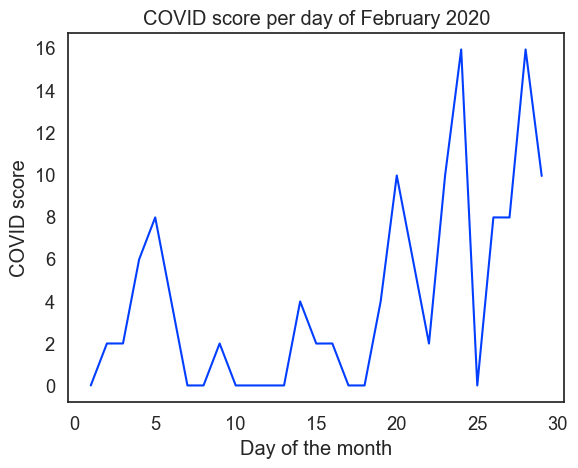

In [ ]:
(sns.lineplot(score, x=score['Date'].dt.day, y='COVID score')
 .set(title='COVID score per day of February 2020', xlabel='Day of the month', ylabel='COVID score'));

This shows spikes near the 6th, 9th, 13th, 20th, and 27th: the same dates that I found flight disruptions during in my EDA.

To find a relationship, I will plot flight cancellations along the COVID score.  
**Remember that the COVID score is the average sum of new COVID cases between origin and destination countries.**  
Each dot on the plot below represents a day.

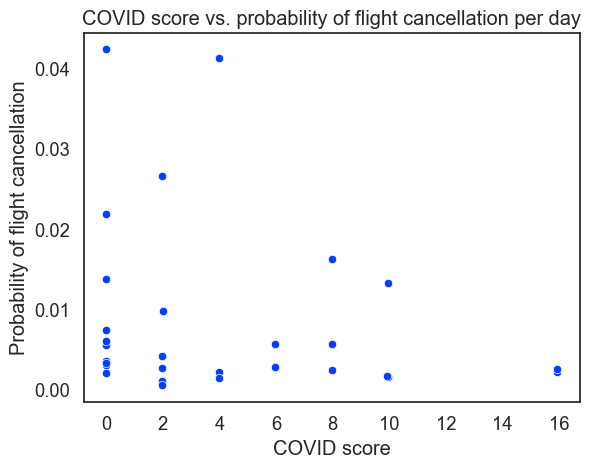

In [ ]:
# COVID score — Flight cancellations
(sns.scatterplot(score, x='COVID score', y='Cancelled')
 .set(title='COVID score vs. probability of flight cancellation per day', xlabel='COVID score', ylabel='Probability of flight cancellation'));

Counterintuitively, it seems that **flights are more likely to be cancelled on days with fewer cases**.  
This goes against my guess that days with more COVID cases would have more flight cancellations.  
I will run a similar plot against departure delays to see if similar results turn up. (From my EDA, I know they likely will.)

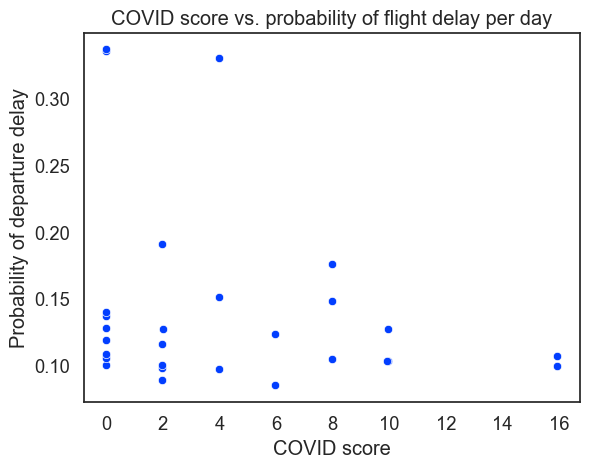

In [ ]:
# COVID score — Flight delays
(sns.scatterplot(score, x='COVID score', y='Departure delayed')
 .set(title='COVID score vs. probability of flight delay per day', xlabel='COVID score', ylabel='Probability of departure delay'));

This shows roughly a similar story: **flights are more likely to be delayed on days with fewer cases**.  
Once again, I did not expect this at all.  
Perhaps this means that flight disruptions somehow result in fewer daily cases. If airports had COVID tests in place, I could see this being the case.

I will plot all of this onto one chart.

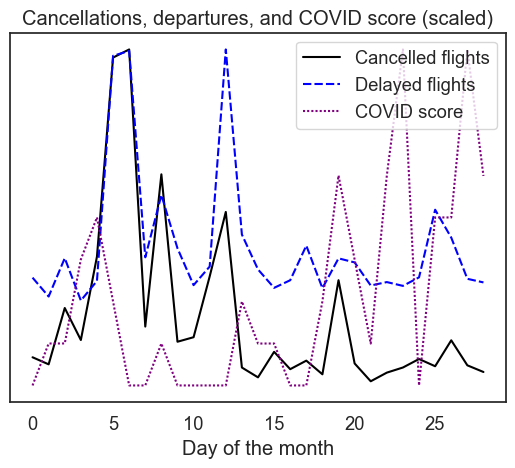

In [ ]:
score_scaled = pd.DataFrame()
score_scaled['Cancelled'] = score['Cancelled'] / np.max(score['Cancelled'])
score_scaled['Departure delayed'] = score['Departure delayed'] / np.max(score['Departure delayed'])
score_scaled['COVID score'] = score['COVID score'] / np.max(score['COVID score'])
ax = sns.lineplot(data=score_scaled[['Cancelled', 'Departure delayed', 'COVID score']], palette=['black', 'blue', 'purple'])
ax.set(title='Cancellations, departures, and COVID score (scaled)', xlabel='Day of the month', yticklabels=[])
ax.legend(ax.legend_.legend_handles, ['Cancelled flights', 'Delayed flights', 'COVID score'], loc='upper right');

Beware: this data is scaled such that all lines have the same height, so the magnitudes don't matter.  
It seems that most spikes in the COVID score are followed by a disruption in the form of a spike in cancelled and / or delayed flights during that day.  
This is the smoking gun because it shows a clear relationship between flight disruptions and the COVID-19 case counts between the origin and destination of booked flights.

---

## Reflection

Here are my takeaways after looking at the data

- **There is indeed a relationship between COVID-19 cases and airlines.**
    - This was what I'd hoped to do, but now I have a clear picture (literally) of this relationship.
    - This indicates either that airlines were affected by case counts, or that airlines played a role in responding to COVID-19.
    - Given that the COVID score lines up _exactly_ with flight cancellations at times and _later_ at others, I imagine it's both.
- **COVID-19 had a lower impact on flight cancellations as the month of February progressed.**
    - This either indicates that airlines stopped caring about COVID-19, or that they got better at dealing with it.
    - Personally, I think it is the latter considering the regulations that airlines are subject to.
    - I expected to see a similar pattern with flight delays, but that's not as clear.
- **The mean number of new COVID-19 cases across the origin and destination of flights during a day doesn't affect cancellations or delays that much.**
    - In fact, it might be more likely for flights to be delayed on days where there were not as many new cases during the day!
    - Case numbers changed a lot during the pandemic, so this shows that **time is a very important variable** when analysing an evolving pandemic like COVID-19.
    - I wonder if there is a way I could analyse this data without involving time.
- **Minimizing the effects of flight disruptions using pandemic data might not be feasible.**
    - Besides waiting for case counts to get lower before traveling, I don't think there is much you can do to prevent your flight from getting delayed or cancelled.
    - Airlines don't cancel flights for no reason, and it makes sense that they would pump the breaks on travel during the outbreak of a disease.
    - Avoiding travel to countries with a high amount of COVID-19 cases might also reduce the probability of a flight getting cancelled.

This was an adventure, and I wasn't sure I'd be able to work with this data.  
However, through many ups and downs, I've obtained _something_ resembling useful information, and that's what data analysis is about.  
Now I just need to cram this onto a dashboard with whatever my teammates come up with.

Thank you for reading this. :^)

_"Flight data analysis? I don't know a lot about airplanes, so I'll have to wing it."_  — Bradan Fleming